This California Housing Prices dataset has been downloaded from the StatLib repository (http://lib.stat.cmu.edu/datasets/). It is based on data from the 1990 California census. It is not recent, but this is not important for deep learning. The original dataset appeared in R. Kelley Pace and Ronald Barry, “Sparse Spatial Autoregressions,” Statistics & Probability Letters 33, no. 3 (1997): 291–297.

Data for each instance (observation) is referred to as a block group in California, which could be corresponded to a district with a population of 600 to 3,000 people, and 1,425.5 on average. 

The original raw dataset contains 20,640 instances. It is cleaned, preprocessed, and prepared in this notebook. After this phase of data preparation, a final dataset of 20,433 cases is obtained with nine attributes individually standardized with a mean of 0 and a variation of 1, $\frac{x-mean}{variance}$, or normalized with a min-max scaling, $\frac{x-min}{max-min}$: *longitude* and *latitude* (location), *median age*, *total rooms*, *total bedrooms*, *population*, *households*,  *median income*, and *ocean proximity*.  The file **MedianHouseValuePreparedCleanAttributes.csv** contains the resulting dataset. 

From this data, the classification problem consists of estimating the median house value, categorized into the following three classes (price intervals in thousand dollars): Cheap: [15.0, 141.3], Averaged: [141.4, 230.2], and Expensive: [230.3, 500.0]. Each class is labeled from 0 (the cheapest) to 2 (the most expensive) and one-hot encoded in <b>MedianHouseValueOneHotEncodedClasses.csv</b> file for supervised training models. 

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14733657367359443997, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8394615607028370932
 physical_device_desc: "device: XLA_CPU device"]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, minmax_scale, scale
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
INPUT_FILE_NAME = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/HousingRawDataset.csv"
ATT_FILE_NAME = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValuePreparedCleanAttributes.csv"
ONE_HOT_ENCODED_LABEL_FILE_NAME = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValueOneHotEncodedClasses.csv"
CONTINUOUS_LABEL_FILE_NAME = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValueContinuousOutput.csv"

In [ ]:
dataset = pd.read_csv(INPUT_FILE_NAME)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
dataset[:10]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [ ]:
dataset[-10:]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20630,-121.32,39.29,11.0,2640.0,505.0,1257.0,445.0,3.5673,112000.0,INLAND
20631,-121.40,39.33,15.0,2655.0,493.0,1200.0,432.0,3.5179,107200.0,INLAND
20632,-121.45,39.26,15.0,2319.0,416.0,1047.0,385.0,3.1250,115600.0,INLAND
20633,-121.53,39.19,27.0,2080.0,412.0,1082.0,382.0,2.5495,98300.0,INLAND
20634,-121.56,39.27,28.0,2332.0,395.0,1041.0,344.0,3.7125,116800.0,INLAND
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**First Step:** find out whether or not there are missing values and, in such case, remove them.

In [ ]:
{att : dataset[dataset[att].isnull()].shape[0] for att in dataset.columns}

{'households': 0,
 'housing_median_age': 0,
 'latitude': 0,
 'longitude': 0,
 'median_house_value': 0,
 'median_income': 0,
 'ocean_proximity': 0,
 'population': 0,
 'total_bedrooms': 207,
 'total_rooms': 0}

*total_bedrooms* has 207 missing values. The corresponding rows are removed.

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
{att : dataset[dataset[att].isnull()].shape[0] for att in dataset.columns}

{'households': 0,
 'housing_median_age': 0,
 'latitude': 0,
 'longitude': 0,
 'median_house_value': 0,
 'median_income': 0,
 'ocean_proximity': 0,
 'population': 0,
 'total_bedrooms': 0,
 'total_rooms': 0}

**Second Step:** check how many instances per labels there are.

In [ ]:
dataset.ocean_proximity.value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

The label *ISLAND* is removed since they are only the following five examples.

In [ ]:
dataset.loc[dataset.ocean_proximity=="ISLAND"]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,ISLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND
8316,-118.32,33.33,52.0,2127.0,512.0,733.0,288.0,3.3906,300000.0,ISLAND
8317,-118.32,33.34,52.0,996.0,264.0,341.0,160.0,2.7361,450000.0,ISLAND
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,287500.0,ISLAND


In [ ]:
dataset.drop(index=range(8314,8319),inplace=True)

In [ ]:
dataset.ocean_proximity.value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
Name: ocean_proximity, dtype: int64

In [ ]:
labels=list(set(dataset.ocean_proximity))
labels

['NEAR OCEAN', '<1H OCEAN', 'INLAND', 'NEAR BAY']

Location of the block groups (houses) included in the clean dataset.

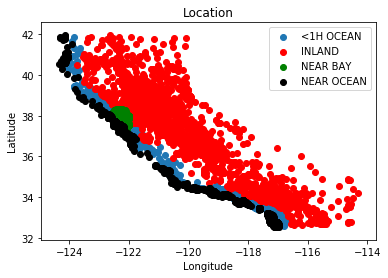

In [ ]:
plt.title("Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.scatter(dataset[dataset["ocean_proximity"]=="<1H OCEAN"]["longitude"], 
            dataset[dataset["ocean_proximity"]=="<1H OCEAN"]["latitude"])
plt.scatter(dataset[dataset["ocean_proximity"]=="INLAND"]["longitude"], 
            dataset[dataset["ocean_proximity"]=="INLAND"]["latitude"],c="r")
plt.scatter(dataset[dataset["ocean_proximity"]=="NEAR BAY"]["longitude"], 
            dataset[dataset["ocean_proximity"]=="NEAR BAY"]["latitude"],c="g")
plt.scatter(dataset[dataset["ocean_proximity"]=="NEAR OCEAN"]["longitude"], 
            dataset[dataset["ocean_proximity"]=="NEAR OCEAN"]["latitude"],c="k")
plt.legend(["<1H OCEAN","INLAND","NEAR BAY","NEAR OCEAN"])
plt.show()

**Third Step:** shuffle the dataset (three times).

In [ ]:
dataset=dataset.sample(frac=1) #frac is the fraction of axis items to return. 1 means all of them
dataset=dataset.sample(frac=1)
dataset=dataset.sample(frac=1).reset_index(drop=True) #Reset index and drop the old one
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.24,33.98,37.0,1196.0,364.0,1622.0,327.0,2.1250,108900.0,<1H OCEAN
1,-122.81,38.08,19.0,1615.0,366.0,815.0,337.0,3.4609,238800.0,NEAR OCEAN
2,-117.08,32.73,36.0,3331.0,643.0,1903.0,622.0,3.6974,122000.0,NEAR OCEAN
3,-117.87,33.91,16.0,2434.0,455.0,1017.0,476.0,4.2188,176300.0,<1H OCEAN
4,-121.34,37.99,14.0,3111.0,498.0,1178.0,525.0,6.5560,234700.0,INLAND


**Fourth Step:** *discretizing* or encoding *ocean proximity* attribute so that the neural network can compute its values.

In [ ]:
encoder = LabelEncoder() # Function that transform non-numeral labels into integers.
dataset.ocean_proximity = encoder.fit_transform(dataset.ocean_proximity.values)
names =  [encoder.inverse_transform([value]) for value in range(4)] #hold the name of each class
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.24,33.98,37.0,1196.0,364.0,1622.0,327.0,2.1250,108900.0,0
1,-122.81,38.08,19.0,1615.0,366.0,815.0,337.0,3.4609,238800.0,3
2,-117.08,32.73,36.0,3331.0,643.0,1903.0,622.0,3.6974,122000.0,3
3,-117.87,33.91,16.0,2434.0,455.0,1017.0,476.0,4.2188,176300.0,0
4,-121.34,37.99,14.0,3111.0,498.0,1178.0,525.0,6.5560,234700.0,1


In [ ]:
{ value: encoder.inverse_transform([value]) for value in range(4)}

{0: array(['<1H OCEAN'], dtype=object),
 1: array(['INLAND'], dtype=object),
 2: array(['NEAR BAY'], dtype=object),
 3: array(['NEAR OCEAN'], dtype=object)}

The **correlation matrix** permits to visualize dependencies between pairs of attributes: values close to -1 or +1 indicate a high correlation. A negative correlation rate means than when the value of an attribute gets high, the value of the other attribute decreases, and vice-versa. Positive correlation values suggest that both features increase or deacrease simultaneously. For example, *population* and *households* have a high positive correlation, while large negative correlations do not occur. *population* and *median_income* are highly uncorrelated.

In [ ]:
dataset.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
longitude,1.000000,-0.924628,-0.109556,0.045555,0.069653,0.100380,0.056604,-0.015464,-0.045642,-0.269361
latitude,-0.924628,1.000000,0.012192,-0.036799,-0.067066,-0.109193,-0.071939,-0.079796,-0.144312,0.219992
housing_median_age,-0.109556,0.012192,1.000000,-0.360634,-0.320486,-0.295715,-0.302714,-0.118191,0.106077,0.069659
total_rooms,0.045555,-0.036799,-0.360634,1.000000,0.930382,0.857273,0.918987,0.197822,0.133516,-0.011017
total_bedrooms,0.069653,-0.067066,-0.320486,0.930382,1.000000,0.877758,0.979740,-0.007767,0.049792,-0.014439
population,0.100380,-0.109193,-0.295715,0.857273,0.877758,1.000000,0.907177,0.004989,-0.025069,-0.069397
households,0.056604,-0.071939,-0.302714,0.918987,0.979740,0.907177,1.000000,0.013350,0.065122,-0.022244
median_income,-0.015464,-0.079796,-0.118191,0.197822,-0.007767,0.004989,0.013350,1.000000,0.688848,-0.046241
median_house_value,-0.045642,-0.144312,0.106077,0.133516,0.049792,-0.025069,0.065122,0.688848,1.000000,0.015981
ocean_proximity,-0.269361,0.219992,0.069659,-0.011017,-0.014439,-0.069397,-0.022244,-0.046241,0.015981,1.000000


**Fifth Step:** for a regression problem, the *continuous_t* label is extracted and normalized. If the problem consists of classifying the *median house value* into three categories, it needs to be discretized. A quantile-based discretization is used. 

In [ ]:
continuous_t = pd.DataFrame(data=dataset["median_house_value"].values,columns=["median_house_value"])
continuous_t = pd.DataFrame (minmax_scale (continuous_t, feature_range=(-1,1)),columns=continuous_t.columns)
#continuous_t = pd.DataFrame (scale (continuous_t),columns=continuous_t.columns)
continuous_t[:10]

,median_house_value
0,-0.612781
1,-0.077113
2,-0.558761
3,-0.334844
4,-0.094020
5,-0.885770
6,-0.854017
7,-0.058969
8,-0.064742
9,0.417730


In [ ]:
labels = pd.qcut(dataset["median_house_value"],3,labels=False)
set(labels)

{0, 1, 2}

In [ ]:
dataset.insert (9,"labels",labels)
dataset[:10]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,labels,ocean_proximity
0,-118.24,33.98,37.0,1196.0,364.0,1622.0,327.0,2.1250,108900.0,0,0
1,-122.81,38.08,19.0,1615.0,366.0,815.0,337.0,3.4609,238800.0,2,3
2,-117.08,32.73,36.0,3331.0,643.0,1903.0,622.0,3.6974,122000.0,0,3
3,-117.87,33.91,16.0,2434.0,455.0,1017.0,476.0,4.2188,176300.0,1,0
4,-121.34,37.99,14.0,3111.0,498.0,1178.0,525.0,6.5560,234700.0,2,1
5,-119.46,35.86,22.0,1750.0,374.0,1113.0,338.0,1.5050,42700.0,0,1
6,-119.65,36.32,11.0,1294.0,314.0,713.0,290.0,1.5433,50400.0,0,1
7,-121.17,38.69,5.0,7138.0,1227.0,2623.0,1139.0,5.6902,243200.0,2,1
8,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,2,2
9,-122.03,37.92,23.0,3318.0,408.0,1124.0,393.0,6.5847,358800.0,2,2


Calculating the *median_house_value* intervals for each label (in thousands).

In [ ]:
intervals={label : [round((dataset.loc[dataset["labels"]==label].min()["median_house_value"])/1000,ndigits=1),
                    round((dataset.loc[dataset["labels"]==label].max()["median_house_value"])/1000,ndigits=1)]
                    for label in range(3)}
intervals

{0: [15.0, 141.3], 1: [141.4, 230.2], 2: [230.3, 500.0]}

In [ ]:
intervals = [str(interval) for interval in intervals.values()]
intervals

['[15.0, 141.3]', '[141.4, 230.2]', '[230.3, 500.0]']

In [ ]:
intervals[0]="Cheap:"+intervals[0]
intervals[1]="Averaged:"+intervals[1]
intervals[2]="Expensive:"+intervals[2]
intervals

['Cheap:[15.0, 141.3]', 'Averaged:[141.4, 230.2]', 'Expensive:[230.3, 500.0]']

In [ ]:
dataset.drop(columns="median_house_value", inplace=True)
dataset[:10]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,labels,ocean_proximity
0,-118.24,33.98,37.0,1196.0,364.0,1622.0,327.0,2.1250,0,0
1,-122.81,38.08,19.0,1615.0,366.0,815.0,337.0,3.4609,2,3
2,-117.08,32.73,36.0,3331.0,643.0,1903.0,622.0,3.6974,0,3
3,-117.87,33.91,16.0,2434.0,455.0,1017.0,476.0,4.2188,1,0
4,-121.34,37.99,14.0,3111.0,498.0,1178.0,525.0,6.5560,2,1
5,-119.46,35.86,22.0,1750.0,374.0,1113.0,338.0,1.5050,0,1
6,-119.65,36.32,11.0,1294.0,314.0,713.0,290.0,1.5433,0,1
7,-121.17,38.69,5.0,7138.0,1227.0,2623.0,1139.0,5.6902,2,1
8,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,2,2
9,-122.03,37.92,23.0,3318.0,408.0,1124.0,393.0,6.5847,2,2


The number of instances per label should be near the same.

In [ ]:
{label : dataset[dataset["labels"]==label].shape[0] for label in set(labels)}

{0: 6812, 1: 6809, 2: 6807}

In [ ]:
dataset["labels"].value_counts()

0    6812
1    6809
2    6807
Name: labels, dtype: int64

In [ ]:
dataset.shape 

(20428, 10)

**Sixth Step:** split the dataset vertically into attributes $x$ and label $t$ for supervised learning.

In [ ]:
discretized_t = pd.DataFrame(data=dataset["labels"].values,columns=["median_house_value"])
discretized_t[:10]

,median_house_value
0,0
1,2
2,0
3,1
4,2
5,0
6,0
7,2
8,2
9,2


In [ ]:
x = dataset.drop (columns="labels")

In [ ]:
x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.24,33.98,37.0,1196.0,364.0,1622.0,327.0,2.1250,0
1,-122.81,38.08,19.0,1615.0,366.0,815.0,337.0,3.4609,3
2,-117.08,32.73,36.0,3331.0,643.0,1903.0,622.0,3.6974,3
3,-117.87,33.91,16.0,2434.0,455.0,1017.0,476.0,4.2188,0
4,-121.34,37.99,14.0,3111.0,498.0,1178.0,525.0,6.5560,1


**Seventh Step:** one-hot encoding of labels (target values).

In [ ]:
encoder = OneHotEncoder(categories="auto") # Function that one-hot encoders integers
one_hot_t = encoder.fit_transform(discretized_t.values.reshape(-1,1)).toarray()
one_hot_t[:10]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
one_hot_t = pd.DataFrame(data=one_hot_t,columns=intervals)
one_hot_t[:10]

,"Cheap:[15.0, 141.3]","Averaged:[141.4, 230.2]","Expensive:[230.3, 500.0]"
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


**Eighth Step:** Standardization or Normalization of the input dataset. *Standardization* is much less affected by outliers, but it does not bound values to a specific range, which may be a problem for neural networks. The center is the mean, and the data is scaled to unit variance. On the other hand, *max-min scaling* ranges the data within max and min values, usually -1, and 1.  

In [ ]:
x = pd.DataFrame (minmax_scale (x, feature_range=(-1,1)),columns=x.columns)
#x = pd.DataFrame (scale (x),columns=x.columns)

In [ ]:
x[:10]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0.217131,-0.693943,0.411765,-0.939264,-0.887337,-0.909246,-0.892781,-0.775851,-1.000000
1,-0.693227,0.177471,-0.294118,-0.917951,-0.886716,-0.954483,-0.889492,-0.591592,1.000000
2,0.448207,-0.959617,0.372549,-0.830663,-0.800745,-0.893495,-0.795757,-0.558972,1.000000
3,0.290837,-0.708820,-0.411765,-0.876291,-0.859094,-0.943160,-0.843776,-0.487055,-1.000000
4,-0.400398,0.158342,-0.490196,-0.841854,-0.845748,-0.934135,-0.827660,-0.164687,-0.333333
5,-0.025896,-0.294368,-0.176471,-0.911084,-0.884233,-0.937779,-0.889163,-0.861367,-0.333333
6,-0.063745,-0.196599,-0.607843,-0.934279,-0.902855,-0.960201,-0.904950,-0.856085,-0.333333
7,-0.366534,0.307120,-0.843137,-0.637011,-0.619491,-0.853135,-0.625719,-0.284106,-0.333333
8,-0.583665,0.128587,1.000000,-0.821914,-0.766915,-0.915861,-0.758921,-0.617854,0.333333
9,-0.537849,0.143464,-0.137255,-0.831324,-0.873681,-0.937162,-0.871074,-0.160729,0.333333


Some **descriptive statistics** on the attributes to confirm the mean and the variance.

In [ ]:
x.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
count,20428.00,20428.00,20428.00,20428.00,20428.00,20428.00,20428.00,20428.00,20428.00
mean,-0.05,-0.34,0.08,-0.87,-0.83,-0.92,-0.84,-0.53,-0.38
std,0.40,0.45,0.49,0.11,0.13,0.06,0.13,0.26,0.69
min,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,-0.49,-0.70,-0.33,-0.93,-0.91,-0.96,-0.91,-0.72,-1.00
50%,0.17,-0.63,0.10,-0.89,-0.87,-0.93,-0.87,-0.58,-0.33
75%,0.26,0.10,0.41,-0.84,-0.80,-0.90,-0.80,-0.41,-0.33
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


**Saving** attributes matrix *x* target labels *t* and continuous target values to csv files.

In [ ]:
x.to_csv (ATT_FILE_NAME, index=False)
one_hot_t.to_csv(ONE_HOT_ENCODED_LABEL_FILE_NAME, index=False)
continuous_t.to_csv(CONTINUOUS_LABEL_FILE_NAME, index=False)